In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

hourly
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
monthly

daily


In [ ]:
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)  # Assuming monthly data
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

In [ ]:
finance_df = pd.read_csv("./Dataset/Monthly.csv")
finance_df['Date'] = pd.to_datetime(finance_df['Date'])
finance_df.drop_duplicates(inplace=True)
finance_df.fillna(method='ffill', inplace=True)
finance_df['close'] = manage_seasonal_cyclic(finance_df['close'])


In [ ]:
environment_df = pd.read_csv("./Dataset/Daily.csv")
environment_df['date'] = pd.to_datetime(environment_df['date'])
environment_df.drop_duplicates(inplace=True)
environment_df.fillna(method='ffill', inplace=True)
environment_df['value'] = manage_seasonal_cyclic(environment_df['value'])

In [ ]:
energy_df = pd.read_csv("./Dataset/Hourly.csv")
energy_df['Datetime'] = pd.to_datetime(energy_df['Datetime'])
energy_df.drop_duplicates(inplace=True)
energy_df.fillna(method='ffill', inplace=True)
energy_df['AEP_MW'] = manage_seasonal_cyclic(energy_df['AEP_MW'])

In [ ]:
print(environment_df.head())
print(energy_df.head())
print(finance_df.head())

        date       value
0 1958-03-30  316.143960
1 1958-03-31  316.397080
2 1958-04-02  317.675747
3 1958-04-03  317.744391
4 1958-04-04  317.089876
             Datetime        AEP_MW
0 2004-12-31 01:00:00  13318.628600
1 2004-12-31 02:00:00  12762.652611
2 2004-12-31 03:00:00  12556.374885
3 2004-12-31 04:00:00  12562.181004
4 2004-12-31 05:00:00  12770.517001
        Date     open     high      low        close
0 2000-01-03  1469.25  1478.00  1438.36  1453.793647
1 2000-01-04  1455.22  1455.22  1397.43  1396.463452
2 2000-01-05  1399.42  1413.27  1377.68  1400.027038
3 2000-01-06  1402.11  1411.90  1392.10  1401.960166
4 2000-01-07  1403.45  1441.47  1400.73  1439.999199


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

# Load the data
environment_df = pd.read_csv('Dataset\Daily.csv')
energy_df = pd.read_csv('Dataset\Hourly.csv')
finance_df = pd.read_csv('Dataset\Monthly.csv')

# Display the first few rows of the data
print(environment_df.head())
print(energy_df.head())
print(finance_df.head())
print(environment_df.info())
print(energy_df.info())
print(finance_df.info())


         date   value
0  1958-03-30  316.16
1  1958-03-31  316.40
2  1958-04-02  317.67
3  1958-04-03  317.76
4  1958-04-04  317.09
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
       Date     open     high      low    close
0  1/3/2000  1469.25  1478.00  1438.36  1455.22
1  1/4/2000  1455.22  1455.22  1397.43  1399.42
2  1/5/2000  1399.42  1413.27  1377.68  1402.11
3  1/6/2000  1402.11  1411.90  1392.10  1403.45
4  1/7/2000  1403.45  1441.47  1400.73  1441.47
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18764 entries, 0 to 18763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18764 non-null  object 
 1   value   18764 non-null  float64
dtypes: float64(1), object(1)
memory usage: 293.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 12

In [ ]:

# Preprocessing Steps

## Cleaning: Identify and impute or remove missing values
def clean_data(df):
    # Identify missing values
    print(df.isnull().sum())
    
    # Impute or remove missing values
    # This is just an example, you might need to handle missing values differently based on your data
    df = df.fillna(method='ffill')
    return df

environment_df = clean_data(environment_df)
energy_df = clean_data(energy_df)
finance_df = clean_data(finance_df)

## Normalization/Standardization: Scale the data to a uniform range
def normalize_data(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df

environment_df = normalize_data(environment_df)
energy_df = normalize_data(energy_df)
finance_df = normalize_data(finance_df)

## Stationarization: Apply differencing and logarithmic transformations as necessary to achieve stationarity
def stationarize_data(df, column):
    # Differencing
    df[column] = df[column] - df[column].shift(1)
    
    # Logarithmic transformation
    df[column] = np.log(df[column])
    
    # Test for stationarity
    result = adfuller(df[column].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    return df

environment_df = stationarize_data(environment_df, 'value')
energy_df = stationarize_data(energy_df, 'AEP_MW')
finance_df = stationarize_data(finance_df, 'close')


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

# Function to normalize data
def normalize_data(df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(df[['value']])  # Assuming 'value' is the column to normalize
    return pd.DataFrame(normalized_data, columns=['normalized_value'])

# Function to check stationarity
def check_stationarity(df):
    result = adfuller(df['value'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# Function to make data stationary (if necessary)
def make_stationary(df):
    # Perform differencing or logarithmic transformation here
    # Example: df['stationary_value'] = df['value'].diff().fillna(0)  # Differencing
    # Example: df['stationary_value'] = np.log(df['value'])  # Log transformation
    return df

# Load the data
environment_df = pd.read_csv('Dataset\Daily.csv')
energy_df = pd.read_csv('Dataset\Hourly.csv')
finance_df = pd.read_csv('Dataset\Monthly.csv')

# Normalize data
environment_df['normalized_value'] = normalize_data(environment_df)
energy_df['normalized_value'] = normalize_data(energy_df)
finance_df['normalized_value'] = normalize_data(finance_df)

# Check stationarity
check_stationarity(environment_df)
check_stationarity(energy_df)
check_stationarity(finance_df)

# Make data stationary if necessary
environment_df = make_stationary(environment_df)
energy_df = make_stationary(energy_df)
finance_df = make_stationary(finance_df)

# Plot normalized data
plt.figure(figsize=(10, 6))
plt.plot(environment_df['date'], environment_df['normalized_value'], label='Environment')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Environment Data')
plt.legend()
plt.show()


KeyError: "None of [Index(['value'], dtype='object')] are in the [columns]"

        date       value
0 1958-03-30  316.143960
1 1958-03-31  316.397080
2 1958-04-02  317.675747
3 1958-04-03  317.744391
4 1958-04-04  317.089876
             Datetime        AEP_MW
0 2004-12-31 01:00:00  13318.628600
1 2004-12-31 02:00:00  12762.652611
2 2004-12-31 03:00:00  12556.374885
3 2004-12-31 04:00:00  12562.181004
4 2004-12-31 05:00:00  12770.517001
        Date     open     high      low        close
0 2000-01-03  1469.25  1478.00  1438.36  1453.793647
1 2000-01-04  1455.22  1455.22  1397.43  1396.463452
2 2000-01-05  1399.42  1413.27  1377.68  1400.027038
3 2000-01-06  1402.11  1411.90  1392.10  1401.960166
4 2000-01-07  1403.45  1441.47  1400.73  1439.999199


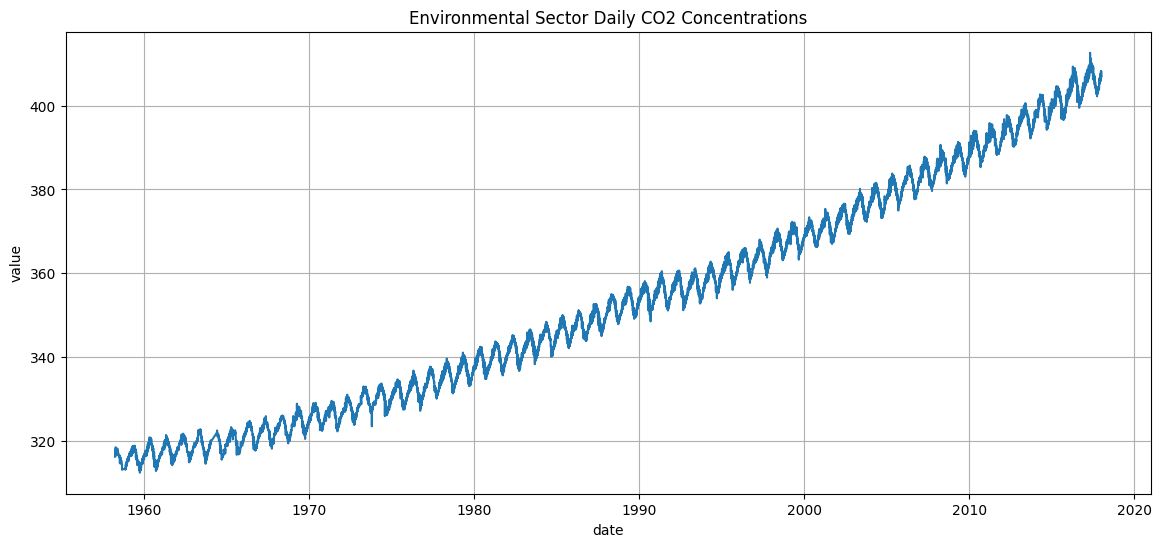

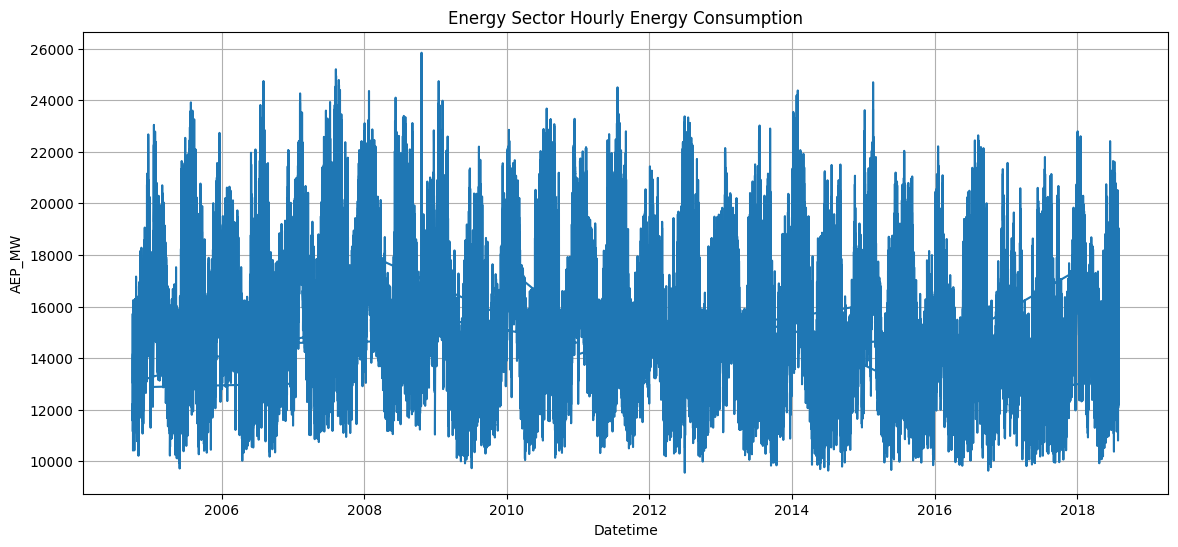

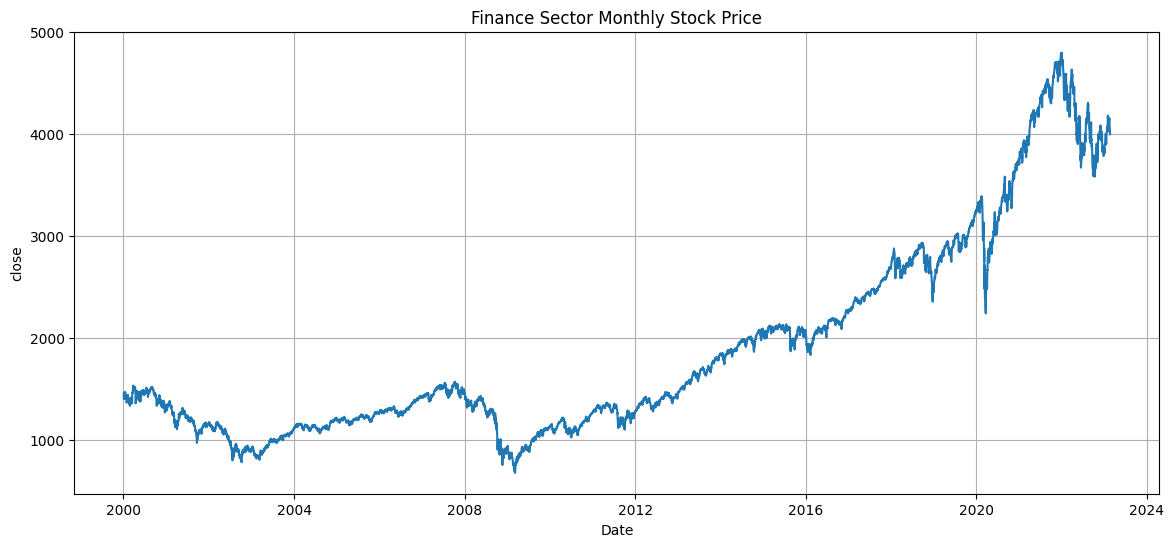

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
def manage_seasonal_cyclic(df):
    # Seasonal decomposition
    decomposition = seasonal_decompose(df, model='additive', period=12)  # Assuming monthly data
    seasonal = decomposition.seasonal
    df_corrected = df - seasonal
    return df_corrected

def data_claning(df, date_column, value_column):
    df[date_column] = pd.to_datetime(df[date_column])
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)
    df[value_column] = manage_seasonal_cyclic(df[value_column])
    return df

finance_df = data_claning(finance_df, 'Date', 'close')
environment_df = data_claning(environment_df, 'date', 'value')
energy_df = data_claning(energy_df, 'Datetime', 'AEP_MW')
print(environment_df.head())
print(energy_df.head())
print(finance_df.head())


def plot_graph(df, date_column, value_column, title):
    plt.figure(figsize=(14, 6))
    plt.plot(df[date_column], df[value_column])
    plt.title(title)
    plt.xlabel(date_column)
    plt.ylabel(value_column)
    plt.grid(True)
    plt.show()

plot_graph(environment_df, 'date', 'value', 'Environmental Sector Daily CO2 Concentrations')
plot_graph(energy_df, 'Datetime', 'AEP_MW', 'Energy Sector Hourly Energy Consumption')
plot_graph(finance_df, 'Date', 'close', 'Finance Sector Monthly Stock Price')

# 


In [15]:
#save data to csv


environment_df.to_csv('environment_df.csv', index=False)
energy_df.to_csv('energy_df.csv', index=False)
finance_df.to_csv('finance_df.csv', index=False)

In [13]:
def check_stationaries(df, column):
    result = adfuller(df[column])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

# make a differece data function using check_stationaries
def difference_data(df, column):
    df['difference'] = df[column] - df[column].shift(1)
    check_stationaries(df, 'difference')
    return df


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    # Split data into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    
    # Make predictions
    predictions = fitted_model.forecast(steps=len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((predictions - test)**2))
    
    return rmse

# Function to find the best ARIMA model parameters
def find_best_arima_parameters(data, p_range, d_range, q_range):
    best_rmse = float('inf')
    best_params = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(data, order)
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = order
                except:
                    continue
    
    return best_params, best_rmse

# Example usage:
# Load the data
# environment_df = pd.read_csv('Dataset/Daily.csv')
# environment_df['date'] = pd.to_datetime(environment_df['date'])
# environment_df.set_index('date', inplace=True)
data = environment_df['value'].values

# Define ranges for ARIMA parameters
p_range = range(0, 3)  # Autoregressive terms
d_range = range(0, 3)  # Differencing
q_range = range(0, 3)  # Moving average terms

# Find the best ARIMA parameters
best_params, best_rmse = find_best_arima_parameters(data, p_range, d_range, q_range)
print("Best ARIMA parameters:", best_params)
print("Best RMSE:", best_rmse)


C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aliar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users

Best ARIMA parameters: (1, 2, 1)
Best RMSE: 3.1574256811829193


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_and_order(data):
    d = 0
    adf_result = adfuller(data)
    while adf_result[1] > 0.05:
        data = np.diff(data)
        d += 1
        adf_result = adfuller(data)
    return d

# Function to check the stationarity of the data
def check_stationarity(data):
    adf_result = adfuller(data)
    return adf_result[1]

# Example usage:
# Load the data
# environment_df = pd.read_csv('Dataset/Daily.csv')
# environment_df['date'] = pd.to_datetime(environment_df['date'])
# environment_df.set_index('date', inplace=True)


Order of differencing (d): 1
ADF p-value: 0.760444269150121


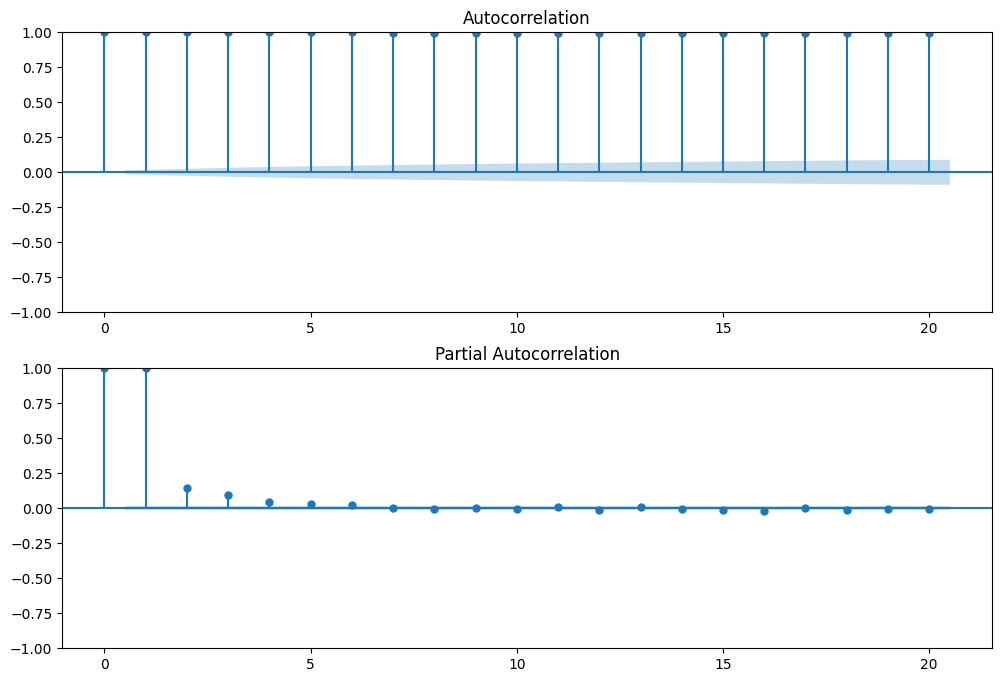

In [24]:
data = environment_df['value'].values

# Difference the data and determine the order of differencing (d)
d = difference_and_order(data)
print("Order of differencing (d):", d)

# Check the stationarity of the data
p_value = check_stationarity(data)
print("ADF p-value:", p_value)

# Plot ACF and PACF plots for parameter estimation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, ax=ax[0], lags=20)
plot_pacf(data, ax=ax[1], lags=20)
plt.show()


Order of differencing (d): 0
ADF p-value: 2.3924187470182788e-29


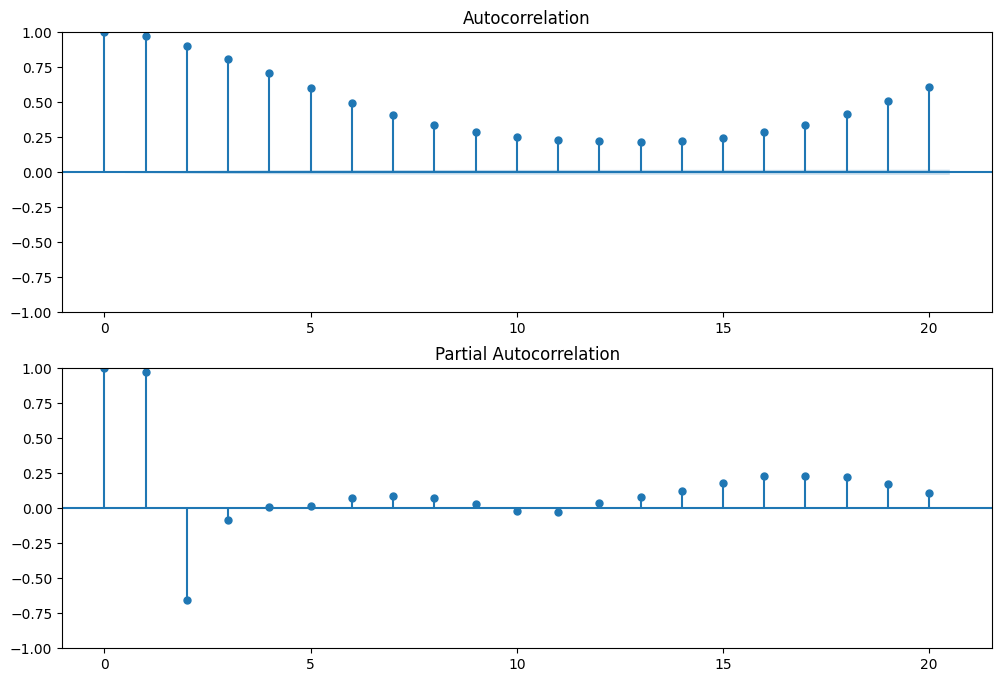

In [25]:
data = energy_df['AEP_MW'].values

# Difference the data and determine the order of differencing (d)
d = difference_and_order(data)
print("Order of differencing (d):", d)

# Check the stationarity of the data
p_value = check_stationarity(data)
print("ADF p-value:", p_value)

# Plot ACF and PACF plots for parameter estimation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, ax=ax[0], lags=20)
plot_pacf(data, ax=ax[1], lags=20)
plt.show()


Order of differencing (d): 1
ADF p-value: 0.9914958358938257


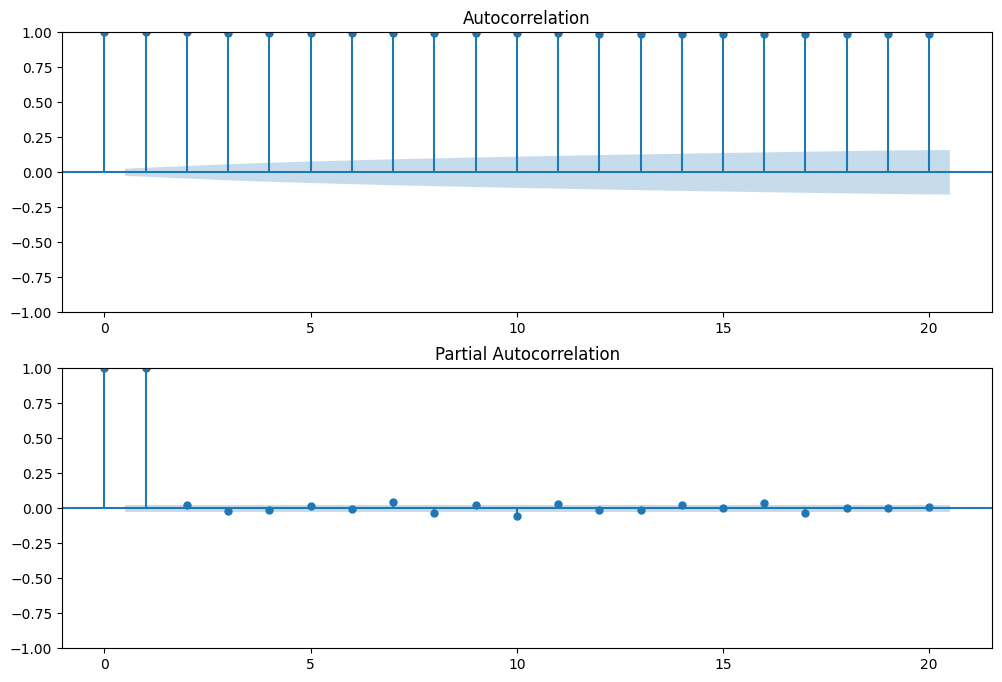

In [26]:
data = finance_df['close'].values

# Difference the data and determine the order of differencing (d)
d = difference_and_order(data)
print("Order of differencing (d):", d)

# Check the stationarity of the data
p_value = check_stationarity(data)
print("ADF p-value:", p_value)

# Plot ACF and PACF plots for parameter estimation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, ax=ax[0], lags=20)
plot_pacf(data, ax=ax[1], lags=20)
plt.show()


enviorment_df:
Order of differencing (d): 1
ADF p-value: 0.760444269150121
financial_df:
Order of differencing (d): 1
ADF p-value: 0.9914958358938257
energy_df:
Order of differencing (d): 0
ADF p-value: 2.3924187470182788e-29

now usese these results to make the arima model
Purpose: ARIMA (Autoregressive Integrated Moving Average) is utilized to model and forecast time
series data that shows levels of non-stationarity or seasonal patterns.
Process: Identify the order of differencing (d), the number of autoregressive terms (p), and the
number of lagged forecast errors in the prediction equation (q) using statistical tests like the ADF
(Augmented Dickey-Fuller) test for stationarity and ACF/PACF plots for parameter estimation.
previous code:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_and_order(data):
    d = 0
    adf_result = adfuller(data)
    while adf_result[1] > 0.05:
        data = np.diff(data)
        d += 1
        adf_result = adfuller(data)
    return d

# Function to check the stationarity of the data
def check_stationarity(data):
    adf_result = adfuller(data)
    return adf_result[1]


data = finance_df['close'].values

# Difference the data and determine the order of differencing (d)
d = difference_and_order(data)
print("Order of differencing (d):", d)

# Check the stationarity of the data
p_value = check_stationarity(data)
print("ADF p-value:", p_value)

# Plot ACF and PACF plots for parameter estimation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, ax=ax[0], lags=20)
plot_pacf(data, ax=ax[1], lags=20)
plt.show()
#for other df
#data = energy_df['AEP_MW'].values
#data = environment_df['value'].values



finance_df
Order of differencing (d): 1
ADF p-value: 0.9914958358938257


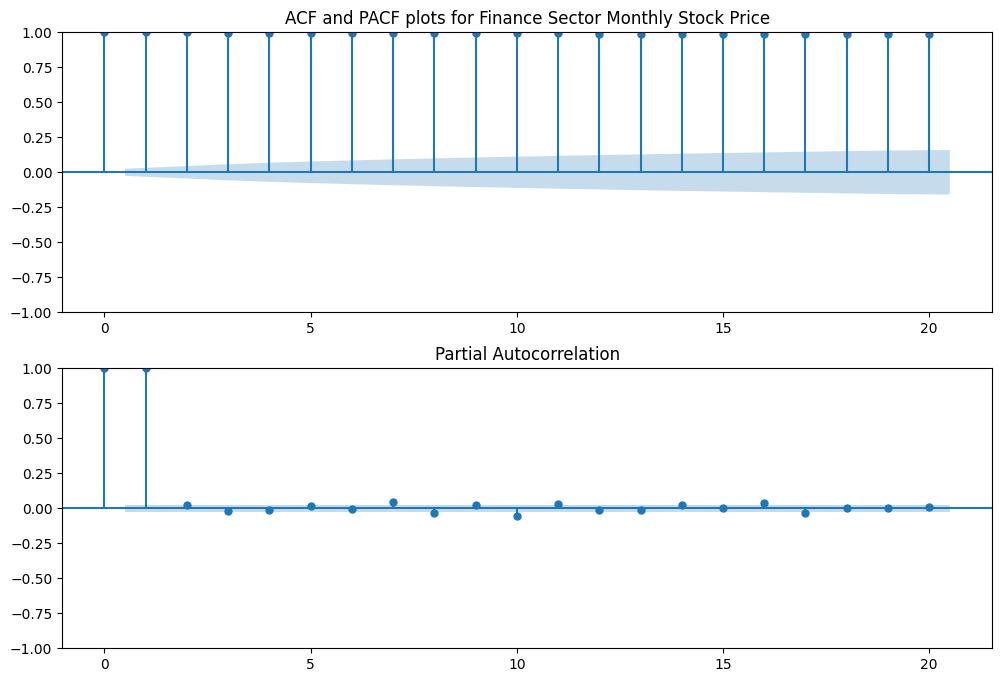

environment_df
Order of differencing (d): 1
ADF p-value: 0.760444269150121


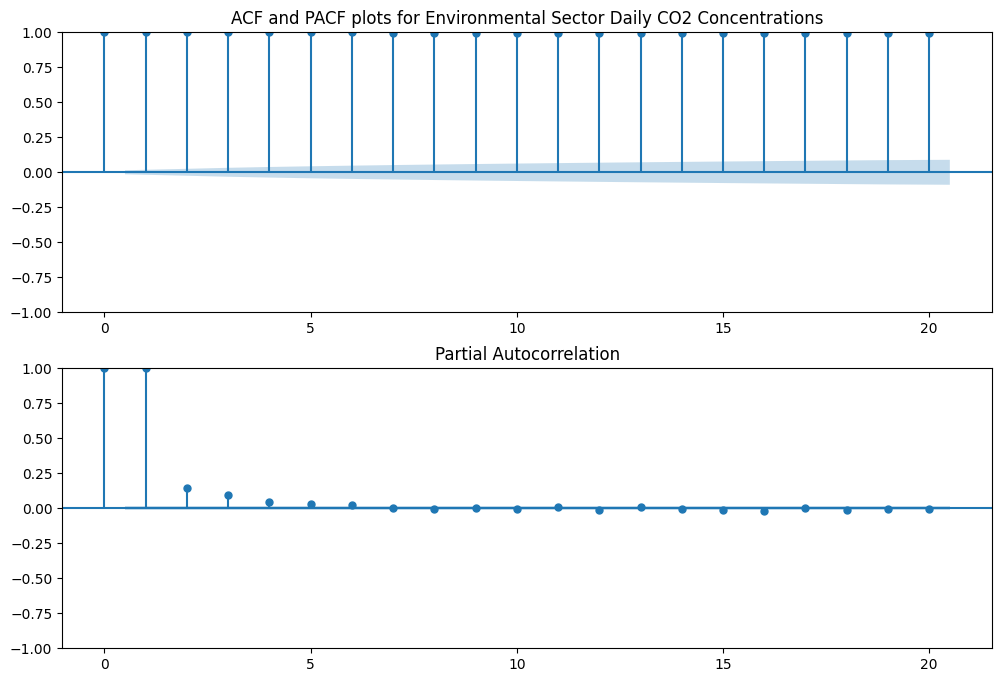

energy_df
Order of differencing (d): 0
ADF p-value: 2.3924187470182788e-29


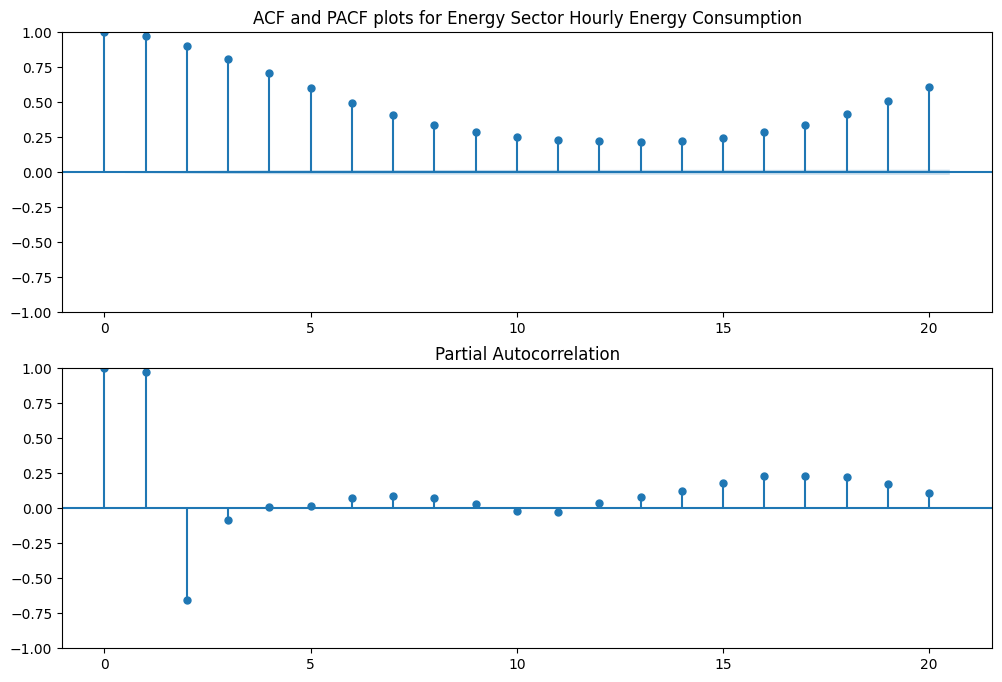

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to difference the data and determine the order of differencing (d)
def difference_and_order(data):
    d = 0
    adf_result = adfuller(data)
    while adf_result[1] > 0.05:
        data = np.diff(data)
        d += 1
        adf_result = adfuller(data)
    return d

# Function to check the stationarity of the data
def check_stationarity(data):
    adf_result = adfuller(data)
    return adf_result[1]

# Function to plot ACF and PACF plots
def plot_acf_pacf(data, title):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(data, ax=ax[0], lags=20)
    plot_pacf(data, ax=ax[1], lags=20)
    ax[0].set_title(f'ACF and PACF plots for {title}')
    plt.show()

def differnce_stationary_values(df, column, title,df_name):
    
    data = df[column].values
    print(df_name)
    # Difference the data and determine the order of differencing (d)
    d = difference_and_order(data)
    print("Order of differencing (d):", d)

    # Check the stationarity of the data
    p_value = check_stationarity(data)
    print("ADF p-value:", p_value)
    plot_acf_pacf(data, title)



differnce_stationary_values(finance_df, 'close', 'Finance Sector Monthly Stock Price', 'finance_df')
differnce_stationary_values(environment_df, 'value', 'Environmental Sector Daily CO2 Concentrations', 'environment_df')
differnce_stationary_values(energy_df, 'AEP_MW', 'Energy Sector Hourly Energy Consumption', 'energy_df')